# Insurance Project - Group 15

$\textit{Noé Debrois \& Vincent Haïk Karakoseian}$

In [283]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [284]:
# Simulation Parameters :
m_MC = 1000000 # Number of simulations
T = 50 # Time horizon in years
N = 50 # Number of time steps
dt = T / N # 1 year time step
sigma_equity = 0.20 # Volatility for equity
sigma_property = 0.10 # Volatility for property

In [285]:
# Parameters (same as in excel file) :
expenses = 50 # Constant unitary cost
EQ0 = 80000 # Initial equity
PR0 = 20000 # Initial property
inflation_rate = 0.02 # Inflation rate
rd_rate = 0.022 # Regular deduction rate
comm_rate = 0.014 # Commission rate
lapse_rate = 0.15  # Annual lapse rate
F0 = 100000 # Initial value of the fund / Premium Invested
comm_benefit = 20 # Commission benefit (when lapse)

In [286]:
def simulate_gbm(initial_price, volatilities, forward_rates, years, num_simulations, rd_rate):
    """
    Simulate GBM paths for the given parameters.

    initial_price: Initial price of the fund.
    volatilities: List of volatilities for each year.
    forward_rates: List of forward rates for each year.
    years: Number of years to simulate.
    num_simulations: Number of simulations to run.
    rd_rate: regular deduction rate.
    
    return: Array of simulated price paths.
    """
    dt = 1  # time step in years
    prices = np.zeros((years + 1, num_simulations))
    prices[0] = initial_price
    for t in range(1, years + 1):
        rate = forward_rates[t - 1]
        vol = volatilities[t - 1]
        z = np.random.standard_normal(num_simulations)
        prices[t] = prices[t - 1] * np.exp((rate - 0.5 * vol ** 2) * dt + vol * np.sqrt(dt) * z) * (1 - rd_rate)
    return prices

## Get the data :

### ISTAT data (Male, Italy)

In [287]:
df_LT = pd.read_excel("LT_M_only.xlsx", skiprows=[0], index_col=0) #  sheet_name='F' for women
Life_table = pd.DataFrame()
Life_table['Age x'] = np.arange(60, 120, 1) # 70 if you want to try older people
Life_table['Probability of death (qx)'] = np.array(df_LT['Probability of death (per thousand)  qx'][60:120]) / 1000

### EIOPA RFR TERM STRUCTURE 31/03/2024
#### $\textit{BASE}$

In [288]:
df = pd.read_excel('RATES.xlsx', "RFR No VA", usecols="A:B")
rt = np.array(df["RFR No VA"]).T
rt = np.array(rt, np.float64)
Years = np.array(df["Years"]).T
# Spotrt is the log of the rate rt
Spotrt = np.log(1 + rt)
# Discount
Discounts = np.exp(-Years * Spotrt) 
# FWD rates 
FWDrt = -np.log(Discounts[1:] / Discounts[:-1])
FWDrt = np.insert(FWDrt, 0, np.NAN)
# Pandas dataframe
EIOPA_yield_curve = pd.DataFrame()
EIOPA_yield_curve['Years'] = Years
EIOPA_yield_curve['RFR No VA'] = rt
EIOPA_yield_curve['Spot rate'] = Spotrt
EIOPA_yield_curve['Discount Factors'] = np.exp(-Years * Spotrt)
EIOPA_yield_curve['FWD rates'] = FWDrt

### EIOPA RFR TERM STRUCTURE 31/03/2024
#### $\textit{UP}$

In [289]:
df = pd.read_excel('RATES.xlsx', "RFR No VA UP", usecols="A:B")
rt = np.array(df["RFR No VA"]).T
rt = np.array(rt, np.float64)
Years = np.array(df["Years"]).T
# Spotrt is the log of the rate rt
Spotrt = np.log(1 + rt)
# Discount
Discounts = np.exp(-Years * Spotrt) 
# FWD rates 
FWDrt = -np.log(Discounts[1:] / Discounts[:-1])
FWDrt = np.insert(FWDrt, 0, np.NAN)
# Pandas dataframe
EIOPA_yield_curve_UP = pd.DataFrame()
EIOPA_yield_curve_UP['Years'] = Years
EIOPA_yield_curve_UP['RFR No VA'] = rt
EIOPA_yield_curve_UP['Spot rate'] = Spotrt
EIOPA_yield_curve_UP['Discount Factors'] = np.exp(-Years * Spotrt)
EIOPA_yield_curve_UP['FWD rates'] = FWDrt

### EIOPA RFR TERM STRUCTURE 31/03/2024
#### $\textit{DOWN}$

In [290]:
df = pd.read_excel('RATES.xlsx', "RFR No VA DW", usecols="A:B")
rt = np.array(df["RFR No VA"]).T
rt = np.array(rt, np.float64)
Years = np.array(df["Years"]).T
# Spotrt is the log of the rate rt
Spotrt = np.log(1 + rt)
# Discount
Discounts = np.exp(-Years * Spotrt) 
# FWD rates 
FWDrt = -np.log(Discounts[1:] / Discounts[:-1])
FWDrt = np.insert(FWDrt, 0, np.NAN)
# Pandas dataframe
EIOPA_yield_curve_DW = pd.DataFrame()
EIOPA_yield_curve_DW['Years'] = Years
EIOPA_yield_curve_DW['RFR No VA'] = rt
EIOPA_yield_curve_DW['Spot rate'] = Spotrt
EIOPA_yield_curve_DW['Discount Factors'] = np.exp(-Years * Spotrt)
EIOPA_yield_curve_DW['FWD rates'] = FWDrt

## Fund projections building blocks

In [291]:
volatilities_EQ = np.full(T, sigma_equity)
volatilities_PR = np.full(T, sigma_property)

## Contract lapse proba (still active)

In [292]:
def compute_CLP(FT, lapse_rate, qx):
    CLP = np.zeros(FT.shape)
    CLP[0] = 1
    for i in range(1, CLP.shape[0]):
        CLP[i] = CLP[i - 1] * (1 - lapse_rate) * (1 - qx[i - 1])
    return CLP

def compute_CLP_MASS(FT, lapse_rate, lapse_MASS, qx):
    CLP = np.zeros(FT.shape)
    CLP[0] = 1
    CLP[1] = CLP[0] * (1 - qx[0]) * (1 - lapse_rate - lapse_MASS)
    for i in range(2, CLP.shape[0]):
        CLP[i] = CLP[i - 1] * (1 - lapse_rate) * (1 - qx[i - 1])
    return CLP

## Cash Flows for the computation of the liabilities

In [293]:
def compute_Expenses(T, expenses, inflation_rate):
    Expenses = np.zeros(T)
    Expenses = np.array([expenses * (1 + inflation_rate) ** i for i in range(T)])
    return Expenses

def compute_COMM(T, comm_rate, rd_rate, FT):
    COMM = np.zeros(T)
    # COMM = comm_rate / (1 - rd_rate) * FT[1:]
    for i in range(T):
        COMM[i] = comm_rate / (1 - rd_rate) * FT[i + 1]
    return COMM

def compute_Lapse(FT, comm_benefit, lapse_rate, qx):
    Lapse = np.zeros(FT.shape[0])
    for i in range(1, FT.shape[0]):
        Lapse[i] = (FT[i] - comm_benefit) * lapse_rate * (1 - qx[i - 1])
    Lapse = Lapse[1:]
    return Lapse

def compute_Lapse_MASS(FT, comm_benefit, lapse_rate, lapse_MASS, qx):
    Lapse = np.zeros(FT.shape[0])
    Lapse[1] = (FT[1] - comm_benefit) * (lapse_rate + lapse_MASS) * (1 - qx[0])
    for i in range(2, FT.shape[0]):
        Lapse[i] = (FT[i] - comm_benefit) * lapse_rate * (1 - qx[i - 1])
    Lapse = Lapse[1:]
    return Lapse

def compute_Death(FT, F0, qx):
    Death = np.zeros(FT.shape[0])
    for i in range(1, FT.shape[0]):
        Death[i] = qx[i - 1] * max(FT[i], F0)
    Death = Death[1:]
    return Death

## Computation of the proba times the cash flows

In [294]:
def expectation_Expenses(Expenses, CLP):
    Expenses = Expenses * CLP[:-1]
    return Expenses

def expectation_COMM(COMM, CLP):
    COMM = COMM * CLP[:-1]
    return COMM

def expectation_Lapse(Lapse, CLP):
    Lapse = Lapse * CLP[:-1]
    return Lapse

def expectation_Death(Death, CLP):
    Death = Death * CLP[:-1]
    return Death

## Computation of the discounted expectation of future cash flows

In [295]:
def discounted_expectation_Expenses(Expenses, Discounts):
    Discounts = Discounts[1:]
    Expenses = Expenses * Discounts
    return Expenses

def discounted_expectation_COMM(COMM, Discounts):
    Discounts = Discounts[1:]
    COMM = COMM * Discounts
    return COMM

def discounted_expectation_Lapse(Lapse, Discounts):
    Discounts = Discounts[1:]
    Lapse = Lapse * Discounts
    return Lapse

def discounted_expectation_Death(Death, Discounts):
    Discounts = Discounts[1:]
    Death = Death * Discounts
    return Death

## BEL \& BOF :

In [296]:
def compute_BEL(Expenses, COMM, Lapse, Death):
    Total = Expenses + COMM + Lapse + Death
    Expenses_tot = np.sum(Expenses)
    COMM_tot = np.sum(COMM)
    Lapse_tot = np.sum(Lapse)
    Death_tot = np.sum(Death)
    Total_Liabilities = np.sum(Total)
    return Expenses_tot, COMM_tot, Lapse_tot, Death_tot, Total_Liabilities

def compute_BOF(ASSET, Total_Liabilities):
    BOF = ASSET - Total_Liabilities
    return BOF

## Base case computations :

In [297]:
# Building blocks
qx = np.array(Life_table['Probability of death (qx)'])
Discounts = np.array(EIOPA_yield_curve['Discount Factors'])
forward_rates = np.array(EIOPA_yield_curve['FWD rates'])
forward_rates = forward_rates[1:]
# Simulate fund
EQ = simulate_gbm(EQ0, volatilities_EQ, forward_rates, T, m_MC, rd_rate)
PR = simulate_gbm(PR0, volatilities_PR, forward_rates, T, m_MC, rd_rate)
FT = EQ + PR
FT = FT
FT = np.mean(FT, axis=1)
# Proba
CLP = compute_CLP(FT, lapse_rate, qx)
# Cash Flows
Expenses = compute_Expenses(T, expenses, inflation_rate)
COMM = compute_COMM(T, comm_rate, rd_rate, FT)
Lapse = compute_Lapse(FT, comm_benefit, lapse_rate, qx)
Death = compute_Death(FT, F0, qx)
# Proba * Cash Flows
Expenses = expectation_Expenses(Expenses, CLP)
COMM = expectation_COMM(COMM, CLP)
Lapse = expectation_Lapse(Lapse, CLP)
Death = expectation_Death(Death, CLP)
# Discounted Expectation
Expenses = discounted_expectation_Expenses(Expenses, Discounts)
COMM = discounted_expectation_COMM(COMM, Discounts)
Lapse = discounted_expectation_Lapse(Lapse, Discounts)
Death = discounted_expectation_Death(Death, Discounts)
Total = Expenses + COMM + Lapse + Death
# BEL
BEL = compute_BEL(Expenses, COMM, Lapse, Death)
# BOF
BOF = compute_BOF(100000, BEL[4])

## IR UP computations :

In [298]:
# Building blocks
forward_rates = np.array(EIOPA_yield_curve_UP['FWD rates'])
forward_rates = forward_rates[1:]
qx = np.array(Life_table['Probability of death (qx)'])
Discounts = np.array(EIOPA_yield_curve_UP['Discount Factors'])
# Simulate GBM
EQ = simulate_gbm(EQ0, volatilities_EQ, forward_rates, T, m_MC, rd_rate)
PR = simulate_gbm(PR0, volatilities_PR, forward_rates, T, m_MC, rd_rate)
FT = EQ + PR
FT = np.mean(FT, axis=1)
# Proba
CLP = compute_CLP(FT, lapse_rate, qx)
# Cash Flows
Expenses = compute_Expenses(T, expenses, inflation_rate)
COMM = compute_COMM(T, comm_rate, rd_rate, FT)
Lapse = compute_Lapse(FT, comm_benefit, lapse_rate, qx)
Death = compute_Death(FT, F0, qx)
# Proba * Cash Flows
Expenses = expectation_Expenses(Expenses, CLP)
COMM = expectation_COMM(COMM, CLP)
Lapse = expectation_Lapse(Lapse, CLP)
Death = expectation_Death(Death, CLP)
# Discounted Expectation
Expenses = discounted_expectation_Expenses(Expenses, Discounts)
COMM = discounted_expectation_COMM(COMM, Discounts)
Lapse = discounted_expectation_Lapse(Lapse, Discounts)
Death = discounted_expectation_Death(Death, Discounts)
Total_IR_UP = Expenses + COMM + Lapse + Death
# BEL
BEL_IR_UP = compute_BEL(Expenses, COMM, Lapse, Death)
# BOF
BOF_IR_UP = compute_BOF(100000, BEL_IR_UP[4])
# DBOF
D_BOF_IR_UP = BOF - BOF_IR_UP

## IR DW computations :

In [299]:
# Building blocks
forward_rates = np.array(EIOPA_yield_curve_DW['FWD rates'])
forward_rates = forward_rates[1:]
qx = np.array(Life_table['Probability of death (qx)'])
Discounts = np.array(EIOPA_yield_curve_DW['Discount Factors'])
# Simulate GBM
EQ = simulate_gbm(EQ0, volatilities_EQ, forward_rates, T, m_MC, rd_rate)
PR = simulate_gbm(PR0, volatilities_PR, forward_rates, T, m_MC, rd_rate)
FT = EQ + PR
FT = np.mean(FT, axis=1)
# Proba
CLP = compute_CLP(FT, lapse_rate, qx)
# Cash Flows
Expenses = compute_Expenses(T, expenses, inflation_rate)
COMM = compute_COMM(T, comm_rate, rd_rate, FT)
Lapse = compute_Lapse(FT, comm_benefit, lapse_rate, qx)
Death = compute_Death(FT, F0, qx)
# Proba * Cash Flows
Expenses = expectation_Expenses(Expenses, CLP)
COMM = expectation_COMM(COMM, CLP)
Lapse = expectation_Lapse(Lapse, CLP)
Death = expectation_Death(Death, CLP)
# Discounted Expectation
Expenses = discounted_expectation_Expenses(Expenses, Discounts)
COMM = discounted_expectation_COMM(COMM, Discounts)
Lapse = discounted_expectation_Lapse(Lapse, Discounts)
Death = discounted_expectation_Death(Death, Discounts)
Total_IR_DW = Expenses + COMM + Lapse + Death
# BEL
BEL_IR_DW = compute_BEL(Expenses, COMM, Lapse, Death)
# BOF
BOF_IR_DW = compute_BOF(100000, BEL_IR_DW[4])
# DBOF
D_BOF_IR_DW = BOF - BOF_IR_DW
# SCRIR :
SCR_IR = max(D_BOF_IR_UP, D_BOF_IR_DW)
SCR_IR = max(SCR_IR, 0)

## EQ computations :

In [300]:
# Building Blocks
forward_rates = np.array(EIOPA_yield_curve['FWD rates'])
forward_rates = forward_rates[1:]
qx = np.array(Life_table['Probability of death (qx)'])
Discounts = np.array(EIOPA_yield_curve['Discount Factors'])
# Simulate GBM
EQ = simulate_gbm(EQ0, volatilities_EQ, forward_rates, T, m_MC, rd_rate)
PR = simulate_gbm(PR0, volatilities_PR, forward_rates, T, m_MC, rd_rate)
FT = (1 - 0.39) * EQ + PR
FT = np.mean(FT, axis=1)
# Proba
CLP = compute_CLP(FT, lapse_rate, qx)
# Cash Flows
Expenses = compute_Expenses(T, expenses, inflation_rate)
COMM = compute_COMM(T, comm_rate, rd_rate, FT)
Lapse = compute_Lapse(FT, comm_benefit, lapse_rate, qx)
Death = compute_Death(FT, F0, qx)
# Proba * Cash Flows
Expenses = expectation_Expenses(Expenses, CLP)
COMM = expectation_COMM(COMM, CLP)
Lapse = expectation_Lapse(Lapse, CLP)
Death = expectation_Death(Death, CLP)
# Discounted Expectation
Expenses = discounted_expectation_Expenses(Expenses, Discounts)
COMM = discounted_expectation_COMM(COMM, Discounts)
Lapse = discounted_expectation_Lapse(Lapse, Discounts)
Death = discounted_expectation_Death(Death, Discounts)
Total_EQ = Expenses + COMM + Lapse + Death
# BEL
BEL_EQ = compute_BEL(Expenses, COMM, Lapse, Death)
# BOF
ASSET_EQ = (1 - 0.39) * 80000 + 20000
BOF_EQ = compute_BOF(ASSET_EQ, BEL_EQ[4])
# DBOF
D_BOF_EQ = BOF - BOF_EQ
# SCR EQ
SCR_EQ = max(D_BOF_EQ, 0)

## PR computations :

In [301]:
# Building Blocks
forward_rates = np.array(EIOPA_yield_curve['FWD rates'])
forward_rates = forward_rates[1:]
qx = np.array(Life_table['Probability of death (qx)'])
Discounts = np.array(EIOPA_yield_curve['Discount Factors'])
# Simulate GBM
EQ = simulate_gbm(EQ0, volatilities_EQ, forward_rates, T, m_MC, rd_rate)
PR = simulate_gbm(PR0, volatilities_PR, forward_rates, T, m_MC, rd_rate)
FT = EQ + (1 - 0.25) * PR
FT = np.mean(FT, axis=1)
# Proba
CLP = compute_CLP(FT, lapse_rate, qx)
# Cash Flows
Expenses = compute_Expenses(T, expenses, inflation_rate)
COMM = compute_COMM(T, comm_rate, rd_rate, FT)
Lapse = compute_Lapse(FT, comm_benefit, lapse_rate, qx)
Death = compute_Death(FT, F0, qx)
# Proba * Cash Flows
Expenses = expectation_Expenses(Expenses, CLP)
COMM = expectation_COMM(COMM, CLP)
Lapse = expectation_Lapse(Lapse, CLP)
Death = expectation_Death(Death, CLP)
# Discounted Expectation
Expenses = discounted_expectation_Expenses(Expenses, Discounts)
COMM = discounted_expectation_COMM(COMM, Discounts)
Lapse = discounted_expectation_Lapse(Lapse, Discounts)
Death = discounted_expectation_Death(Death, Discounts)
Total_PR = Expenses + COMM + Lapse + Death
# BEL
BEL_PR = compute_BEL(Expenses, COMM, Lapse, Death)
# BOF
ASSET_PR = 80000 + (1 - 0.25) * 20000
BOF_PR = compute_BOF(ASSET_PR, BEL_PR[4])
# DBOF
D_BOF_PR = BOF - BOF_PR
# SCR PR
SCR_PR = max(D_BOF_PR, 0)

## LAPSE UP computations :

In [302]:
# Building Blocks 
forward_rates = np.array(EIOPA_yield_curve['FWD rates'])
forward_rates = forward_rates[1:]
lapse_rate_up = 0.225
qx = np.array(Life_table['Probability of death (qx)'])
Discounts = np.array(EIOPA_yield_curve['Discount Factors'])
# Simulate GBM
EQ = simulate_gbm(EQ0, volatilities_EQ, forward_rates, T, m_MC, rd_rate)
PR = simulate_gbm(PR0, volatilities_PR, forward_rates, T, m_MC, rd_rate)
FT = EQ + PR
FT = np.mean(FT, axis=1)
# Proba
CLP = compute_CLP(FT, lapse_rate_up, qx)
# Cash Flows 
Expenses = compute_Expenses(T, expenses, inflation_rate)
COMM = compute_COMM(T, comm_rate, rd_rate, FT)
Lapse = compute_Lapse(FT, comm_benefit, lapse_rate_up, qx)
Death = compute_Death(FT, F0, qx)
# Proba * Cash Flows
Expenses = expectation_Expenses(Expenses, CLP)
COMM = expectation_COMM(COMM, CLP)
Lapse = expectation_Lapse(Lapse, CLP)
Death = expectation_Death(Death, CLP)
# Discounted Expectation
Expenses = discounted_expectation_Expenses(Expenses, Discounts)
COMM = discounted_expectation_COMM(COMM, Discounts)
Lapse = discounted_expectation_Lapse(Lapse, Discounts)
Death = discounted_expectation_Death(Death, Discounts)
Total_L_UP = Expenses + COMM + Lapse + Death
# BEL
BEL_L_UP = compute_BEL(Expenses, COMM, Lapse, Death)
# BOF
BOF_L_UP = compute_BOF(100000, BEL_L_UP[4])
# DBOF
D_BOF_L_UP = BOF - BOF_L_UP

## LAPSE DW computations :

In [303]:
# Building Blocks
forward_rates = np.array(EIOPA_yield_curve['FWD rates'])
forward_rates = forward_rates[1:]
lapse_rate_dw = 0.075
qx = np.array(Life_table['Probability of death (qx)'])
Discounts = np.array(EIOPA_yield_curve['Discount Factors'])
# Simulate GBM
EQ = simulate_gbm(EQ0, volatilities_EQ, forward_rates, T, m_MC, rd_rate)
PR = simulate_gbm(PR0, volatilities_PR, forward_rates, T, m_MC, rd_rate)
FT = EQ + PR
FT = np.mean(FT, axis=1)
# Proba
CLP = compute_CLP(FT, lapse_rate_dw, qx)
# Cash Flows
Expenses = compute_Expenses(T, expenses, inflation_rate)
COMM = compute_COMM(T, comm_rate, rd_rate, FT)
Lapse = compute_Lapse(FT, comm_benefit, lapse_rate_dw, qx)
Death = compute_Death(FT, F0, qx)
# Proba * Cash Flows
Expenses = expectation_Expenses(Expenses, CLP)
COMM = expectation_COMM(COMM, CLP)
Lapse = expectation_Lapse(Lapse, CLP)
Death = expectation_Death(Death, CLP)
# Discounted Expectation
Expenses = discounted_expectation_Expenses(Expenses, Discounts)
COMM = discounted_expectation_COMM(COMM, Discounts)
Lapse = discounted_expectation_Lapse(Lapse, Discounts)
Death = discounted_expectation_Death(Death, Discounts)
Total_L_DW = Expenses + COMM + Lapse + Death
# BEL
BEL_L_DW = compute_BEL(Expenses, COMM, Lapse, Death)
# BOF
BOF_L_DW = compute_BOF(100000, BEL_L_DW[4])
# DBOF
D_BOF_L_DW = BOF - BOF_L_DW

## LAPSE MASS computations :

In [304]:
# Building Blocks
forward_rates = np.array(EIOPA_yield_curve['FWD rates'])
forward_rates = forward_rates[1:]
lapse_MASS = 0.4
qx = np.array(Life_table['Probability of death (qx)'])
Discounts = np.array(EIOPA_yield_curve['Discount Factors'])
# Simulate GBM
EQ = simulate_gbm(EQ0, volatilities_EQ, forward_rates, T, m_MC, rd_rate)
PR = simulate_gbm(PR0, volatilities_PR, forward_rates, T, m_MC, rd_rate)
FT = EQ + PR
FT = np.mean(FT, axis=1)
# Proba
CLP = compute_CLP_MASS(FT, lapse_rate, lapse_MASS, qx)
# Cash Flows
Expenses = compute_Expenses(T, expenses, inflation_rate)
COMM = compute_COMM(T, comm_rate, rd_rate, FT)
Lapse = compute_Lapse_MASS(FT, comm_benefit, lapse_rate, lapse_MASS, qx)
Death = compute_Death(FT, F0, qx)
# Proba * Cash Flows
Expenses = expectation_Expenses(Expenses, CLP)
COMM = expectation_COMM(COMM, CLP)
Lapse = expectation_Lapse(Lapse, CLP)
Death = expectation_Death(Death, CLP)
# Discounted Expectation
Expenses = discounted_expectation_Expenses(Expenses, Discounts)
COMM = discounted_expectation_COMM(COMM, Discounts)
Lapse = discounted_expectation_Lapse(Lapse, Discounts)
Death = discounted_expectation_Death(Death, Discounts)
Total_L_MASS = Expenses + COMM + Lapse + Death
# BEL
BEL_L_MASS = compute_BEL(Expenses, COMM, Lapse, Death)
# BOF
BOF_L_MASS = compute_BOF(100000, BEL_L_MASS[4])
# DBOF
D_BOF_L_MASS = BOF - BOF_L_MASS
# SCR LAPSE
SCR_L = max(D_BOF_L_UP, D_BOF_L_DW, D_BOF_L_MASS)
SCR_L = max(SCR_L, 0)

## CAT computations :

In [305]:
# Building Blocks
forward_rates = np.array(EIOPA_yield_curve['FWD rates'])
forward_rates = forward_rates[1:]
CAT_shock = 0.0015
qx = np.array(Life_table['Probability of death (qx)'])
qx[0] = qx[0] + CAT_shock
Discounts = np.array(EIOPA_yield_curve['Discount Factors'])
# Simulate GBM
EQ = simulate_gbm(EQ0, volatilities_EQ, forward_rates, T, m_MC, rd_rate)
PR = simulate_gbm(PR0, volatilities_PR, forward_rates, T, m_MC, rd_rate)
FT = EQ + PR
FT = np.mean(FT, axis=1)
# Proba
CLP = compute_CLP(FT, lapse_rate, qx)
# Cash Flows
Expenses = compute_Expenses(T, expenses, inflation_rate)
COMM = compute_COMM(T, comm_rate, rd_rate, FT)
Lapse = compute_Lapse(FT, comm_benefit, lapse_rate, qx)
Death = compute_Death(FT, F0, qx)
# Proba * Cash Flows
Expenses = expectation_Expenses(Expenses, CLP)
COMM = expectation_COMM(COMM, CLP)
Lapse = expectation_Lapse(Lapse, CLP)
Death = expectation_Death(Death, CLP)
# Discounted Expectation
Expenses = discounted_expectation_Expenses(Expenses, Discounts)
COMM = discounted_expectation_COMM(COMM, Discounts)
Lapse = discounted_expectation_Lapse(Lapse, Discounts)
Death = discounted_expectation_Death(Death, Discounts)
Total_CAT = Expenses + COMM + Lapse + Death
# BEL
BEL_CAT = compute_BEL(Expenses, COMM, Lapse, Death)
# BOF
BOF_CAT = compute_BOF(100000, BEL_CAT[4])
# DBOF
D_BOF_CAT = BOF - BOF_CAT
# SCR CAT
SCR_CAT = max(0, D_BOF_CAT)

## MORTALITY computations :

In [306]:
# Building Blocks
forward_rates = np.array(EIOPA_yield_curve['FWD rates'])
forward_rates = forward_rates[1:]
qx = np.array(Life_table['Probability of death (qx)'])
qx = 1.15 * qx
Discounts = np.array(EIOPA_yield_curve['Discount Factors'])
# Simulate GBM
EQ = simulate_gbm(EQ0, volatilities_EQ, forward_rates, T, m_MC, rd_rate)
PR = simulate_gbm(PR0, volatilities_PR, forward_rates, T, m_MC, rd_rate)
FT = EQ + PR
FT = np.mean(FT, axis=1)
# Proba
CLP = compute_CLP(FT, lapse_rate, qx)
# Caash Flows
Expenses = compute_Expenses(T, expenses, inflation_rate)
COMM = compute_COMM(T, comm_rate, rd_rate, FT)
Lapse = compute_Lapse(FT, comm_benefit, lapse_rate, qx)
Death = compute_Death(FT, F0, qx)
# Proba * Cash Flows
Expenses = expectation_Expenses(Expenses, CLP)
COMM = expectation_COMM(COMM, CLP)
Lapse = expectation_Lapse(Lapse, CLP)
Death = expectation_Death(Death, CLP)
# Discounted Expectation
Expenses = discounted_expectation_Expenses(Expenses, Discounts)
COMM = discounted_expectation_COMM(COMM, Discounts)
Lapse = discounted_expectation_Lapse(Lapse, Discounts)
Death = discounted_expectation_Death(Death, Discounts)
Total_MOR = Expenses + COMM + Lapse + Death
# BEL
BEL_MOR = compute_BEL(Expenses, COMM, Lapse, Death)
# BOF
BOF_MOR = compute_BOF(100000, BEL_MOR[4])
# DBOF
D_BOF_MOR = BOF - BOF_MOR
# SCR MORTALITY
SCR_MOR = max(0, D_BOF_MOR)

## EXPENSES computations :

In [307]:
# Building Blocks
forward_rates = np.array(EIOPA_yield_curve['FWD rates'])
forward_rates = forward_rates[1:]
inflation_rate_up = 0.03
expenses_up = 1.1 * expenses
qx = np.array(Life_table['Probability of death (qx)'])
Discounts = np.array(EIOPA_yield_curve['Discount Factors'])
# Simulate GBM
EQ = simulate_gbm(EQ0, volatilities_EQ, forward_rates, T, m_MC, rd_rate)
PR = simulate_gbm(PR0, volatilities_PR, forward_rates, T, m_MC, rd_rate)
FT = EQ + PR
FT = np.mean(FT, axis=1)
# Proba
CLP = compute_CLP(FT, lapse_rate, qx)
# Cash Flows
Expenses = compute_Expenses(T, expenses_up, inflation_rate_up)
COMM = compute_COMM(T, comm_rate, rd_rate, FT)
Lapse = compute_Lapse(FT, comm_benefit, lapse_rate, qx)
Death = compute_Death(FT, F0, qx)
# Proba * Cash Flows
Expenses = expectation_Expenses(Expenses, CLP)
COMM = expectation_COMM(COMM, CLP)
Lapse = expectation_Lapse(Lapse, CLP)
Death = expectation_Death(Death, CLP)
# Discounted Expectation
Expenses = discounted_expectation_Expenses(Expenses, Discounts)
COMM = discounted_expectation_COMM(COMM, Discounts)
Lapse = discounted_expectation_Lapse(Lapse, Discounts)
Death = discounted_expectation_Death(Death, Discounts)
Total_EXP = Expenses + COMM + Lapse + Death
# BEL
BEL_EXP = compute_BEL(Expenses, COMM, Lapse, Death)
# BOF
BOF_EXP = compute_BOF(100000, BEL_EXP[4])
# DBOF
D_BOF_EXP = BOF - BOF_EXP
# SCR EXPENSES 
SCR_EXP = max(0, D_BOF_EXP)

## BSCR :

In [308]:
MARKET = np.array([[1, 0.5, 0.5],
                  [0.5, 1, 0.75],
                  [0.5, 0.75, 1]]) 
LIFE = np.array([[1, 0, 0.25, 0.25],
                [0, 1, 0.25, 0.5],
                [0.25, 0.25, 1, 0.25],
                [0.25, 0.5, 0.25, 1]])
LIFE_MARKET = np.array([[1, 0.25],
                       [0.25, 1]])

In [309]:
def SCR_market(SCR_IR, SCR_EQ, SCR_PR, MARKET):
    X = np.array([SCR_IR, SCR_EQ, SCR_PR])
    SCR_MKT = np.sqrt(np.dot(np.dot(X, MARKET), X.T))
    return SCR_MKT

def SCR_life(SCR_MORT, SCR_LAPSE, SCR_CAT, SCR_EXP, LIFE):
    X = np.array([SCR_MORT, SCR_LAPSE, SCR_EXP, SCR_CAT])
    SCR_LIFE = np.sqrt(np.dot(np.dot(X, LIFE), X.T))
    return SCR_LIFE

def BSCR(SCR_MKT, SCR_LIFE, LIFE_MARKET):
    X = np.array([SCR_MKT, SCR_LIFE])
    BSCR = np.sqrt(np.dot(np.dot(X, LIFE_MARKET), X.T))
    return BSCR

In [310]:
SCR_MKT = SCR_market(SCR_IR, SCR_EQ, SCR_PR, MARKET)
SCR_LIFE = SCR_life(SCR_MOR, SCR_L, SCR_CAT, SCR_EXP, LIFE)
BSCR = BSCR(SCR_MKT, SCR_LIFE, LIFE_MARKET)

In [311]:
SCR_LIFE, SCR_MKT, BSCR

(1396.6113543953522, 4117.284630712576, 4666.656108799248)

In [312]:
def compute_Duration(liab_yearly, Years, BEL):
    DUR = np.matmul(liab_yearly.T, Years) / BEL
    return DUR

Years = np.array(EIOPA_yield_curve['Years'])
Years = Years[1:]

DUR = compute_Duration(Total, Years, BEL[4])
DUR_IR_UP = compute_Duration(Total_IR_UP, Years, BEL_IR_UP[4])
DUR_IR_DW = compute_Duration(Total_IR_DW, Years, BEL_IR_DW[4])
DUR_EQ = compute_Duration(Total_EQ, Years, BEL_EQ[4])
DUR_PR = compute_Duration(Total_PR, Years, BEL_PR[4])
DUR_MOR = compute_Duration(Total_MOR, Years, BEL_MOR[4])
DUR_L_UP = compute_Duration(Total_L_UP, Years, BEL_L_UP[4])
DUR_L_DW = compute_Duration(Total_L_DW, Years, BEL_L_DW[4])
DUR_L_MASS = compute_Duration(Total_L_MASS, Years, BEL_L_MASS[4])
DUR_EXP = compute_Duration(Total_EXP, Years, BEL_EXP[4])
DUR_CAT = compute_Duration(Total_CAT, Years, BEL_CAT[4])

## Displaying the results

In [313]:
FINAL_RESULTS = pd.DataFrame()
FINAL_RESULTS["MVA"] = np.array([100000, 100000, 100000, 68800, 95000, 100000, 100000, 100000, 100000, 100000, 100000])
FINAL_RESULTS["BEL"] = np.array([BEL[4], BEL_IR_UP[4], BEL_IR_DW[4], BEL_EQ[4], BEL_PR[4], BEL_MOR[4], BEL_L_UP[4], BEL_L_DW[4], BEL_L_MASS[4], BEL_EXP[4], BEL_CAT[4]])
FINAL_RESULTS["BOF"] = np.array([BOF, BOF_IR_UP, BOF_IR_DW, BOF_EQ, BOF_PR, BOF_MOR, BOF_L_UP, BOF_L_DW, BOF_L_MASS, BOF_EXP, BOF_CAT])
FINAL_RESULTS["DBOF"] = np.array([0, D_BOF_IR_UP, D_BOF_IR_DW, D_BOF_EQ, D_BOF_PR, D_BOF_MOR, D_BOF_L_UP, D_BOF_L_DW, D_BOF_L_MASS, D_BOF_EXP, D_BOF_CAT])
FINAL_RESULTS["SCR"] = np.array([0, 0, SCR_IR, SCR_EQ, SCR_PR, SCR_MOR, 0, 0, SCR_L, SCR_EXP, SCR_CAT])
FINAL_RESULTS["DUR"] = np.array([DUR, DUR_IR_UP, DUR_IR_DW, DUR_EQ, DUR_PR, DUR_MOR, DUR_L_UP, DUR_L_DW, DUR_L_MASS, DUR_EXP, DUR_CAT])

In [314]:
FINAL_RESULTS

,MVA,BEL,BOF,DBOF,SCR,DUR
0,100000,96296.684689,3703.315311,0.000000,0.000000,5.660518
1,100000,95787.133647,4212.866353,-509.551042,0.000000,5.614384
2,100000,96848.614781,3151.385219,551.930092,551.930092,5.707723
3,68800,68461.566859,338.433141,3364.882170,3364.882170,5.777065
4,95000,91859.453541,3140.546459,562.768852,562.768852,5.675155
5,100000,96320.578686,3679.421314,23.893997,23.893997,5.621246
6,100000,97091.729979,2908.270021,795.045290,0.000000,4.026888
7,100000,95269.696534,4730.303466,-1026.988154,0.000000,9.273778
8,100000,97692.150133,2307.849867,1395.465445,1395.465445,3.433399
9,100000,96300.369404,3699.630596,3.684716,3.684716,5.661288


In [315]:
import pandas as pd

df = pd.DataFrame(FINAL_RESULTS)

# Export the dataframe to an Excel file
df.to_excel('dataframe.xlsx', index=False)

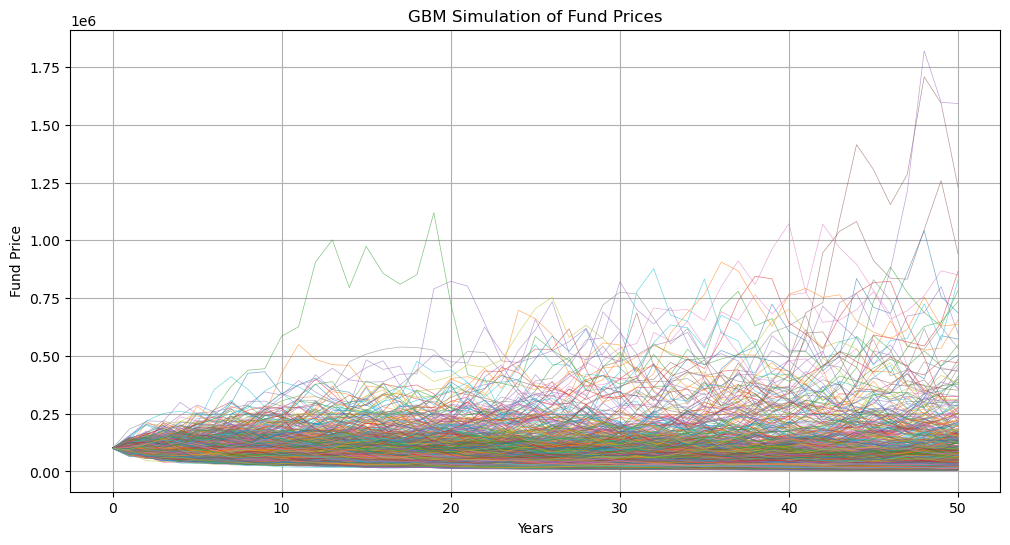

In [316]:
plt.figure(figsize=(12, 6))
for i in range(m_MC//1000):
    plt.plot(EQ[:, i] + PR[:, i], lw=0.5, alpha=0.6)
plt.title('GBM Simulation of Fund Prices')
plt.xlabel('Years')
plt.ylabel('Fund Price')
plt.grid(True)
plt.show()